In [10]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [11]:
from lc_utils import load_imu_data
from submap import Submap
from lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

In [12]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

In [23]:
max_frames = 32000 
# data_dir = "/atidata/demo/SLLumax/2021-07/21-07-2021/map_raw_data/2021-07-21-10-50-46-mini20-02-manual-sllmax_map/"
data_dir =r"/atidata/customer/Bosch/2021-08-30-16-24-40-minimule-11-3-manual-Bosch-32beam_capture_2"
bootstrap_frames =20

grid_res = 0.02
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 100,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)



zmin, zmax = 0.3, 2.5

In [24]:
z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

Using Z slices: [(0.3, 2.5)]


In [25]:
imu_data = load_imu_data(data_dir)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1


In [26]:
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()
spose = pose #local submap pose

In [27]:
submaps, active_submaps, finished_submaps = [], [], [] #active_submaps contain two two at a time -- implementation for overlapping submaps
best_scores = []
node_poses = [] #? poses of inserted frames in the global frame
inserted_frame_ids=[] #frame_id for inserted frame
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

In [28]:
frame_id=0
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)
num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.5)
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    
    if frame_id < start_frame + bootstrap_frames:
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose)) # pose wrt submap origin
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
#         frame_list.append(frame_id)
#         poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])
    
    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose) #only theta around which we need to search changes
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    best = np.argmax(scores)
    best_scores.append(scores[best])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.1 or (prev_insert_ts - frame_time)>1) :

        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
        
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finished = True
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    if frame_id % 250 == 0:
        print(f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  ")
    prev_frame_time, prev_frame = frame_time, frame
node_poses = np.array(node_poses)
inserted_frame_ids = np.array(inserted_frame_ids)
# print(f"final pose {poses[-1]}")
    

total frames 13132
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19
frame:250 scores:2015.0 best pose:[ 0.04000318 -0.01612066  1.57309069]  
frame:500 scores:1662.0 best pose:[ 1.22652608e-03 -3.19554822e-02  1.56925488e+00]  
frame:750 scores:1859.0 best pose:[-0.03668044 -0.00711798  1.57319037]  
frame:1000 scores:2057.0 best pose:[ 0.00366197 -0.02230231  1.56870702]  
frame:1250 scores:3532.0 best pose:[1.01146795 8.06711779 0.08818039]  
frame:1500 scores:6936.0 best pose:[1.32846076e+01

<IPython.core.display.Javascript object>


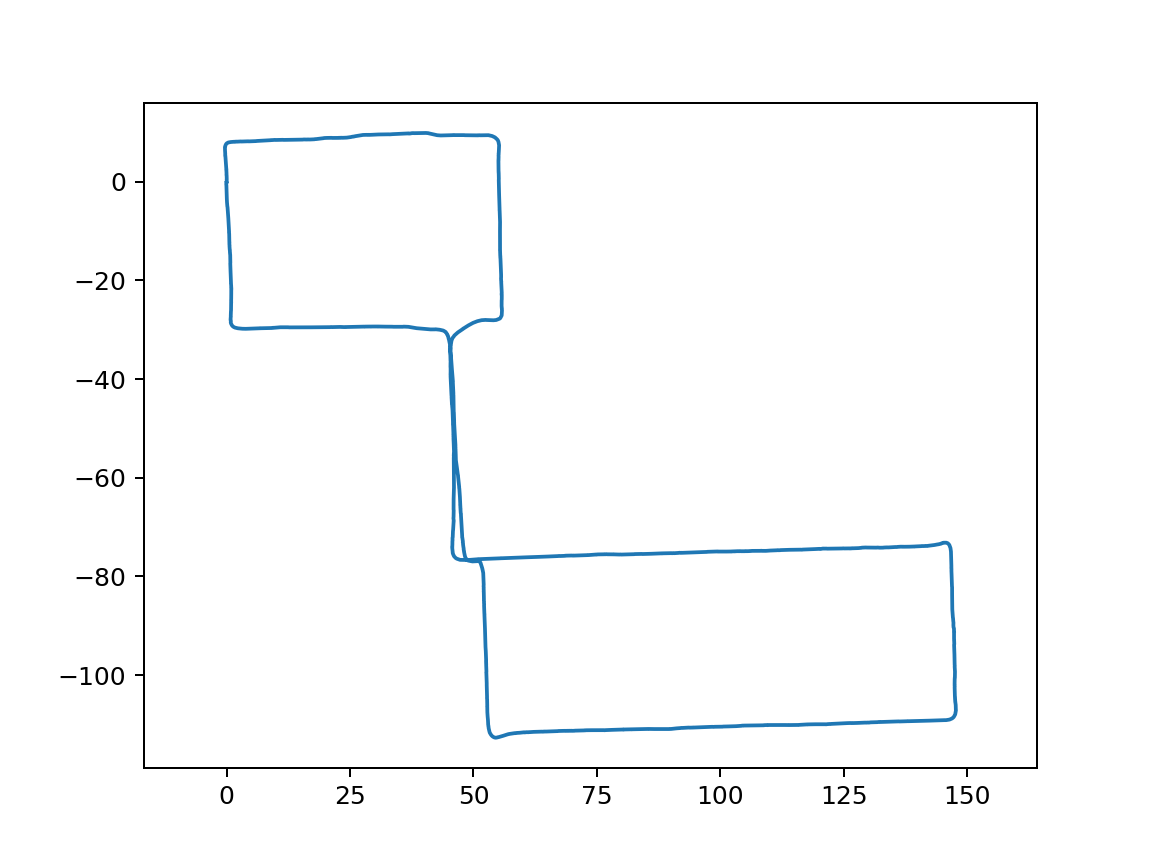

(-7.78950775707035, 155.16822889913075, -118.80586688512852, 16.00316140707165)

In [29]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')


<IPython.core.display.Javascript object>


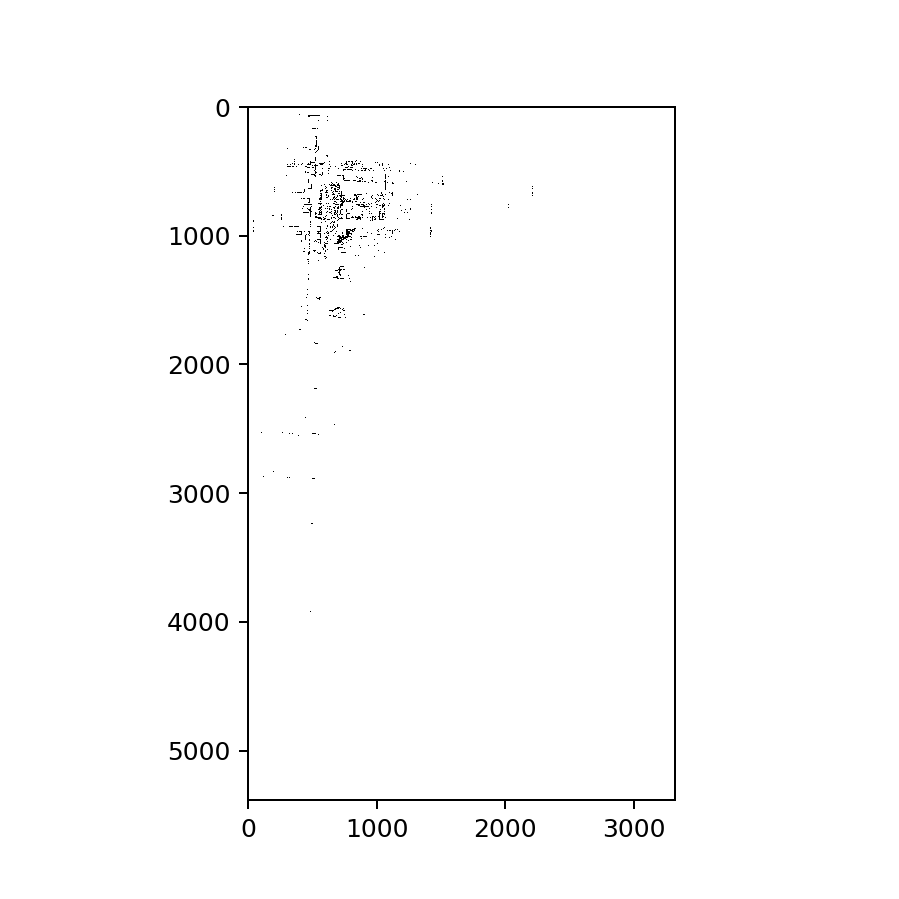

In [20]:
#%matplotlib inline
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,5))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
plt.imshow(1 - (finished_submaps[0].grid.grid.T>0), cmap='gray') 
#print(np.sum(finished_submaps[1].grid.grid >0))

In [ ]:
print( len(finished_submaps), len(node_poses), len(inserted_frame_ids))

In [30]:
import branch_bound as bb
from importlib import reload
from constraint import Constraint
import pg

reload(pg)

<module 'pg' from '/home/anujraaj/helpers/anujraaj/loop_closure/pg.py'>

In [31]:
x_search_window = (-10,10)
y_search_window = (-10,10)
angle_search_window = (-np.pi/6, np.pi/6)

node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))

4313 4313


In [ ]:
constraints=[]
for sid in range(len(finished_submaps)):
#for sid in range(2):
    submap = finished_submaps[sid]
    hgrids =  bb.compute_hierarchical_grid(submap.grid, num_levels=4)
    for nid in range(len(node_poses)):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < 10):
            fr_id = inserted_frame_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose = bb.hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = 10)
            print("sid, nids, pose",[submap.node_ids[0], nid], hpose)
            if hpose is not None:                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))

/home/anujraaj/mule/.venv/lib/python3.7/site-packages/numba/core/typed_passes.py:332: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "branch_bound.py", line 30:
@numba.njit(fastmath=True, parallel=True)                    
def compute_half_res_grid(half_res_grid, full_res_grid):
^

  state.func_ir.loc))


Score below thresold 10 score :9.76040703052729
sid, nids, pose [0, 4236] None
Score below thresold 10 score :9.527015793848712
sid, nids, pose [0, 4237] None
Score below thresold 10 score :9.190355329949238
sid, nids, pose [0, 4238] None
Score below thresold 10 score :6.547120418848167
sid, nids, pose [0, 4239] None
Score below thresold 10 score :7.24820788530466
sid, nids, pose [0, 4240] None
Score below thresold 10 score :9.935749588138385
sid, nids, pose [0, 4241] None
Score below thresold 10 score :9.31692573402418
sid, nids, pose [0, 4242] None
Score below thresold 10 score :8.621527777777779
sid, nids, pose [0, 4243] None
Score below thresold 10 score :9.231082180634662
sid, nids, pose [0, 4244] None
Score below thresold 10 score :9.648
sid, nids, pose [0, 4245] None
Score below thresold 10 score :9.727347611202635
sid, nids, pose [0, 4246] None
Score below thresold 10 score :9.845283018867924
sid, nids, pose [0, 4247] None
Score below thresold 10 score :9.229102167182663
sid, n

Score below thresold 10 score :6.504302925989673
sid, nids, pose [44, 4284] None
Score below thresold 10 score :6.744454303460515
sid, nids, pose [44, 4285] None
Score below thresold 10 score :7.063864187550525
sid, nids, pose [44, 4286] None
Score below thresold 10 score :6.751666666666667
sid, nids, pose [44, 4287] None
Score below thresold 10 score :7.101276595744681
sid, nids, pose [44, 4288] None
Score below thresold 10 score :7.230645161290322
sid, nids, pose [44, 4289] None
Score below thresold 10 score :7.192910140148393
sid, nids, pose [44, 4290] None
Score below thresold 10 score :7.488294314381271
sid, nids, pose [44, 4291] None
Score below thresold 10 score :8.909176029962547
sid, nids, pose [44, 4292] None
Score below thresold 10 score :8.664728682170542
sid, nids, pose [44, 4293] None
Score below thresold 10 score :8.688651794374394
sid, nids, pose [44, 4294] None
Score below thresold 10 score :9.279260780287474
sid, nids, pose [44, 4295] None
Score below thresold 10 scor

In [45]:
#DO i need to explicitly add the vanilla constraints from scan matching?

In [66]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)


In [67]:
ps = pg.PoseGraphOptimization()
for i in range(len(g2o_nps)):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
for i in range(len(g2o_nps)-1):
    ps.add_edge_from_state([i,i+1], information=np.identity(3))
for i in range(len(g2o_cons)-1):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 *np.identity(3))
    
ps.optimize()
oposes=[]
for i in range(len(g2o_nps)):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

In [65]:
oposes

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.25736204e-05,  1.91930371e-04, -1.83163262e-04],
       [ 8.51471382e-05,  3.83860765e-04, -3.66326722e-04],
       ...,
       [-4.67795750e-01, -3.10875070e-02,  1.58778432e+00],
       [-2.11424880e-01, -5.77792862e-02,  1.58303120e+00],
       [-1.12093255e-01, -3.64290350e-02,  1.58575808e+00]])

<IPython.core.display.Javascript object>


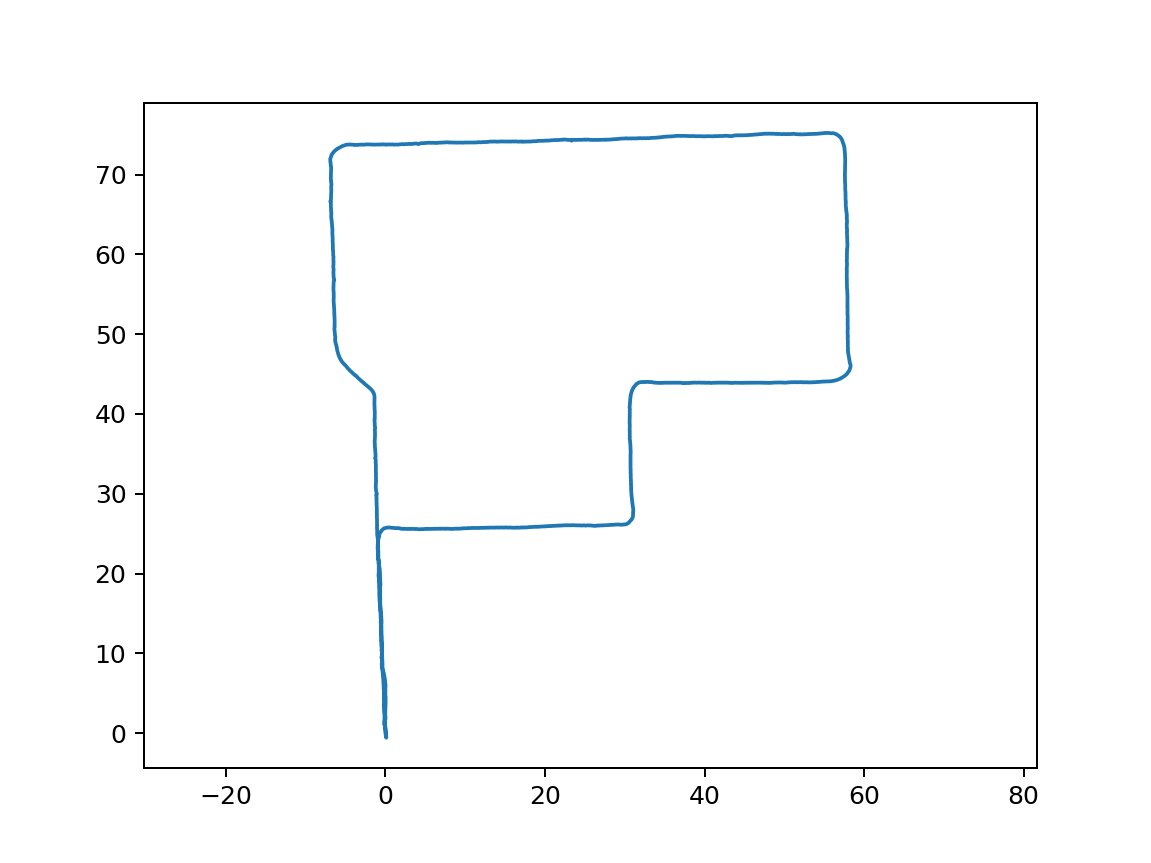

(-10.184242434773722,
 61.56379820710717,
 -4.3695713393604585,
 79.02243831664961)

In [71]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
# plt.plot(oposes[st:stp,0], oposes[st:stp,1], )
plt.axis('equal')